In [ ]:
!pip install uv
!uv pip install --system colpali_engine>=0.3.1 datasets huggingface_hub[hf_transfer] qdrant-client transformers>=4.45.0 stamina rich

Using Python 3.11.12 environment at: /usr
Audited 7 packages in 471ms


In [ ]:
import os
import torch
import numpy as np
from qdrant_client import QdrantClient
from qdrant_client.http import models
from tqdm import tqdm
from datasets import load_dataset


In [ ]:
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"

https://huggingface.co/datasets/hwyin04/pdf-test

In [ ]:
dataset = load_dataset("hwyin04/pdf-test", split="train")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
dataset

Dataset({
    features: ['image'],
    num_rows: 7
})

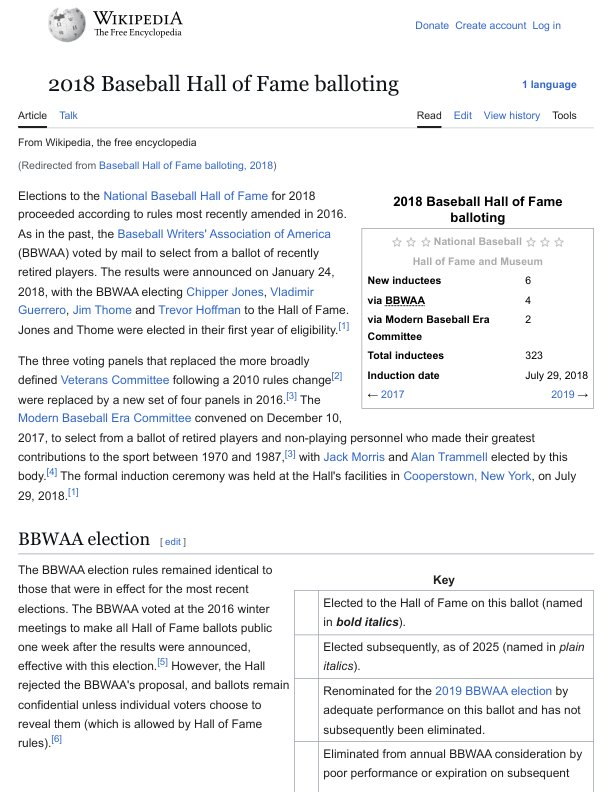

In [ ]:
dataset['image'][0]

In [ ]:
qdrant_client = QdrantClient(
    ":memory:"
)  # Use ":memory:" for in-memory database or "path/to/db" for persistent storage

In [ ]:
from colpali_engine.models import ColPali, ColPaliProcessor

colpali_model = ColPali.from_pretrained(
    "vidore/colpali-v1.2",
    torch_dtype=torch.bfloat16,
    device_map="cuda:0",  # or "mps" if on Apple Silicon
)
colpali_processor = ColPaliProcessor.from_pretrained("vidore/colpaligemma-3b-pt-448-base")

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
sample_image = dataset[0]["image"]
with torch.no_grad():
    sample_batch = colpali_processor.process_images([sample_image]).to(
        colpali_model.device
    )
    sample_embedding = colpali_model(**sample_batch)

In [ ]:
sample_embedding

tensor([[[-0.0913,  0.0361,  0.0874,  ...,  0.1582, -0.0251,  0.1211],
         [-0.0757, -0.0076,  0.0552,  ...,  0.0889, -0.0522,  0.1030],
         [ 0.0248,  0.2012,  0.1211,  ..., -0.0962, -0.1855, -0.0615],
         ...,
         [-0.0625, -0.0488,  0.1279,  ..., -0.0703,  0.1562,  0.0518],
         [-0.1611,  0.0050,  0.0962,  ...,  0.0217, -0.0068, -0.0767],
         [-0.0474,  0.1162,  0.2246,  ...,  0.0747, -0.1108, -0.1621]]],
       device='cuda:0', dtype=torch.bfloat16)

In [ ]:
collection = 'ufo'

In [ ]:
vector_params = models.VectorParams(
    size=128,
    distance=models.Distance.COSINE,
    multivector_config=models.MultiVectorConfig(
        comparator=models.MultiVectorComparator.MAX_SIM
    ),
)
print(vector_params)

size=128 distance=<Distance.COSINE: 'Cosine'> hnsw_config=None quantization_config=None on_disk=None datatype=None multivector_config=MultiVectorConfig(comparator=<MultiVectorComparator.MAX_SIM: 'max_sim'>)


In [ ]:
scalar_quant = models.ScalarQuantizationConfig(
    type=models.ScalarType.INT8,
    quantile=0.99,
    always_ram=True
)

In [ ]:
qdrant_client.recreate_collection(
    collection_name=collection,  # the name of the collection
    on_disk_payload=True,  # store the payload on disk
    optimizers_config=models.OptimizersConfigDiff(
        indexing_threshold=10
    ),  # it can be useful to swith this off when doing a bulk upload and then manually trigger the indexing once the upload is done
    vectors_config=models.VectorParams(
        size=128,
        distance=models.Distance.COSINE,
        multivector_config=models.MultiVectorConfig(
            comparator=models.MultiVectorComparator.MAX_SIM
        ),
        quantization_config=models.ScalarQuantization(
            scalar=models.ScalarQuantizationConfig(
                type=models.ScalarType.INT8,
                quantile=0.99,
                always_ram=True,
            ),
        ),
    ),
)

<ipython-input-16-1c8ca0d4b7bb>:1: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  qdrant_client.recreate_collection(


True

We use the stamina library to enable retries in case of network issues (I didn’t have any issues with the in-memory client, but having this in place can be useful if you are doing a large upload).

In [ ]:
import stamina

@stamina.retry(on=Exception, attempts=3)
def upsert_to_qdrant(batch):
    try:
        qdrant_client.upsert(
            collection_name=collection,
            points=points,
            wait=False,
        )
    except Exception as e:
        print(f"Error during upsert: {e}")
        return False
    return True



In [ ]:
batch_size = 6

with tqdm(total=len(dataset),desc='Indexing Progress') as pbar:
  for i in range(0, len(dataset),batch_size):
    batch = dataset[i:i+batch_size]

    images = batch["image"]

    # Process and encode images
    with torch.no_grad():
        batch_images = colpali_processor.process_images(images).to(
            colpali_model.device
        )
        image_embeddings = colpali_model(**batch_images)

    # Prepare points for QDrant
    points = []
    for j, embedding in enumerate(image_embeddings):
      # Convert the embedding to a list vectors
      multivector = embedding.cpu().float().numpy().tolist()
      points.append(
          models.PointStruct(
              id=i+j, # index as ID
              vector=multivector,
              payload={
                  'source':'internet archive'
              }, # can add other metadata
          )
      )
      # Upload Points to Qdrant
      try:
        upsert_to_qdrant(points)
      except Exception as e:
        print(f"Error during upsert: {e}")
        continue

      pbar.update(batch_size)

print("Indexing Complete")



Indexing Progress: 42it [00:21,  1.99it/s]

Indexing Complete


In [ ]:
from rich import print as r_print

collection = qdrant_client.get_collection(collection)
r_print(collection)

CollectionInfo(
    status=<CollectionStatus.GREEN: 'green'>,
    optimizer_status=<OptimizersStatusOneOf.OK: 'ok'>,
    vectors_count=None,
    indexed_vectors_count=0,
    points_count=7,
    segments_count=1,
    config=CollectionConfig(
        params=CollectionParams(
            vectors=VectorParams(
                size=128,
                distance=<Distance.COSINE: 'Cosine'>,
                hnsw_config=None,
                quantization_config=ScalarQuantization(
                    scalar=ScalarQuantizationConfig(
                        type=<ScalarType.INT8: 'int8'>,
                        quantile=0.99,
                        always_ram=True
                    )
                ),
                on_disk=None,
                datatype=None,
                multivector_config=MultiVectorConfig(comparator=<MultiVectorComparator.MAX_SIM: 'max_sim'>)
            ),
            shard_number=None,
            sharding_method=None,
            replication_factor=None,
            write_consistency_factor=None,
            read_fan_out_factor=None,
            on_disk_payload=None,
            sparse_vectors=None
        ),
        hnsw_config=HnswConfig(
            m=16,
            ef_construct=100,
            full_scan_threshold=10000,
            max_indexing_threads=0,
            on_disk=None,
            payload_m=None
        ),
        optimizer_config=OptimizersConfig(
            deleted_threshold=0.2,
            vacuum_min_vector_number=1000,
            default_segment_number=0,
            max_segment_size=None,
            memmap_threshold=None,
            indexing_threshold=20000,
            flush_interval_sec=5,
            max_optimization_threads=1
        ),
        wal_config=WalConfig(wal_capacity_mb=32, wal_segments_ahead=0),
        quantization_config=None,
        strict_mode_config=None
    ),
    payload_schema={}
)

In [ ]:
qdrant_client.scroll(collection_name='ufo', limit=5)

([Record(id=0, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
  Record(id=1, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
  Record(id=2, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
  Record(id=3, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
  Record(id=4, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None)],
 5)

In [ ]:
query_text = "Trevor Hoffman"
with torch.no_grad():
    batch_query = colpali_processor.process_queries([query_text]).to(
        colpali_model.device
    )
    query_embedding = colpali_model(**batch_query)
query_embedding

tensor([[[ 0.1543, -0.0258,  0.1113,  ..., -0.0287, -0.0815, -0.0273],
         [ 0.0444, -0.1123,  0.0569,  ...,  0.0771, -0.0400,  0.0270],
         [-0.0669, -0.0479,  0.1416,  ..., -0.0286, -0.0564,  0.0366],
         ...,
         [-0.0767, -0.0466,  0.0332,  ..., -0.0786,  0.0486,  0.1533],
         [-0.0815, -0.0500,  0.0271,  ..., -0.0728,  0.0515,  0.1543],
         [-0.0361, -0.0835,  0.0962,  ...,  0.0210, -0.0540, -0.0005]]],
       device='cuda:0', dtype=torch.bfloat16)

In [ ]:
query_embedding[0].shape

torch.Size([16, 128])

In [ ]:
# Convert the query embedding to a list of vectors
multivector_query = query_embedding[0].cpu().float().numpy().tolist()

In [ ]:
# Search in Qdrant
search_result = qdrant_client.query_points(
    collection_name='ufo', query=multivector_query, limit=5, timeout=60
)

search_result.points

[ScoredPoint(id=1, version=0, score=11.591750314773417, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=0, version=0, score=10.739710751595428, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=2, version=0, score=10.737906813167864, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=4, version=0, score=6.800275185002351, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=5, version=0, score=6.5582579115052, payload={'source': 'internet archive'}, vector=None, shard_key=None, order_value=None)]

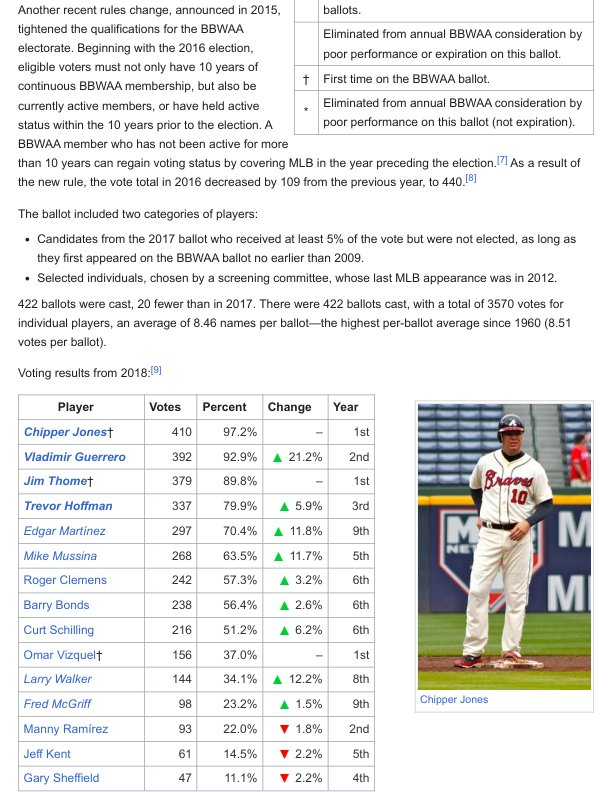

In [ ]:
idx = search_result.points[0].id
dataset[idx]["image"]

In [ ]:
def search_images_by_text(query_text, top_k=5):
    # Process and encode the text query
    with torch.no_grad():
        batch_query = colpali_processor.process_queries([query_text]).to(
            colpali_model.device
        )
        query_embedding = colpali_model(**batch_query)

    # Convert the query embedding to a list of vectors
    multivector_query = query_embedding[0].cpu().float().numpy().tolist()
    # Search in Qdrant
    search_result = qdrant_client.query_points(
        collection_name='ufo', query=multivector_query, limit=top_k
    )

    return search_result


# Example usage
query_text = "2023 ballot"
results = search_images_by_text(query_text)

for result in results.points:
    print(result)

id=0 version=0 score=12.034321176938736 payload={'source': 'internet archive'} vector=None shard_key=None order_value=None
id=2 version=0 score=11.813397899730857 payload={'source': 'internet archive'} vector=None shard_key=None order_value=None
id=1 version=0 score=10.930522890305992 payload={'source': 'internet archive'} vector=None shard_key=None order_value=None
id=4 version=0 score=10.90976356761745 payload={'source': 'internet archive'} vector=None shard_key=None order_value=None
id=5 version=0 score=10.543119533342784 payload={'source': 'internet archive'} vector=None shard_key=None order_value=None


In [ ]:
def search_by_text_and_return_images(query_text, top_k=5):
    results = search_images_by_text(query_text, top_k)
    row_ids = [r.id for r in results.points]
    return dataset.select(row_ids)

Image {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=612x792 at 0x7AE3051E2D50>}


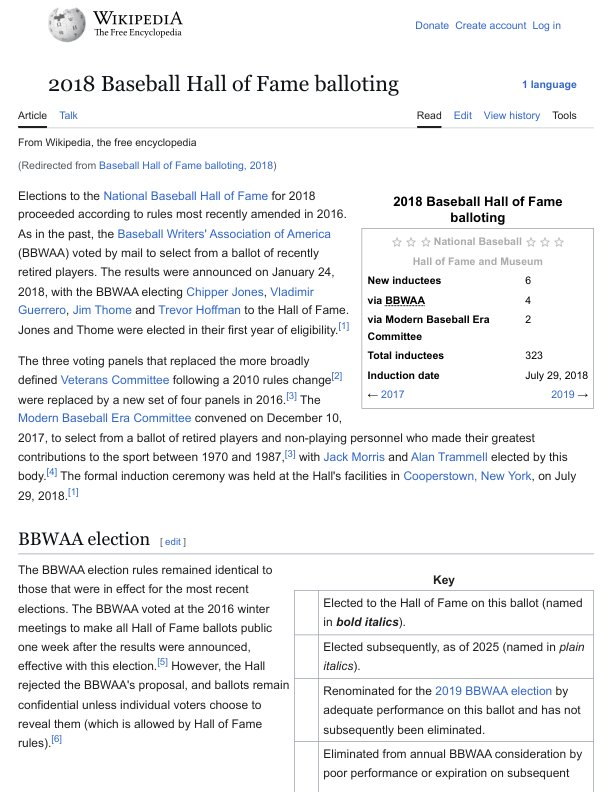

Image {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=612x792 at 0x7AE3051E2590>}


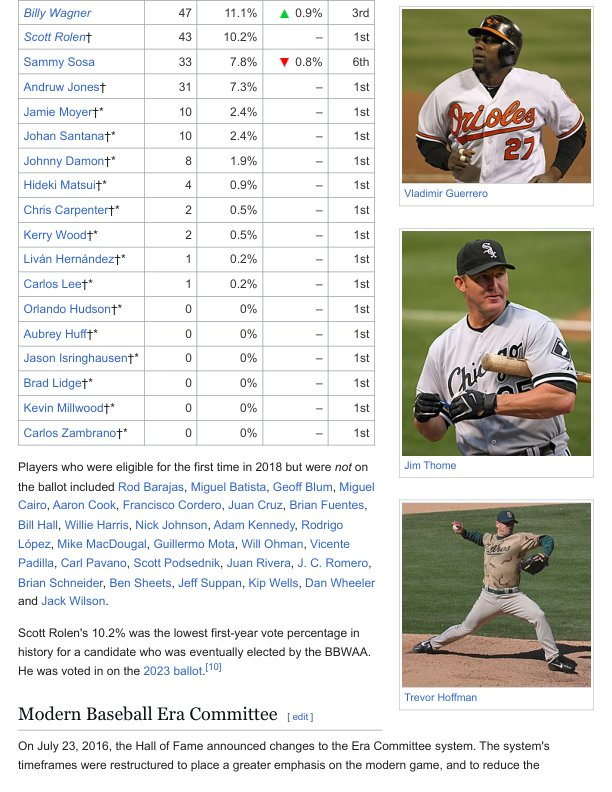

Image {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=612x792 at 0x7AE3051E2550>}


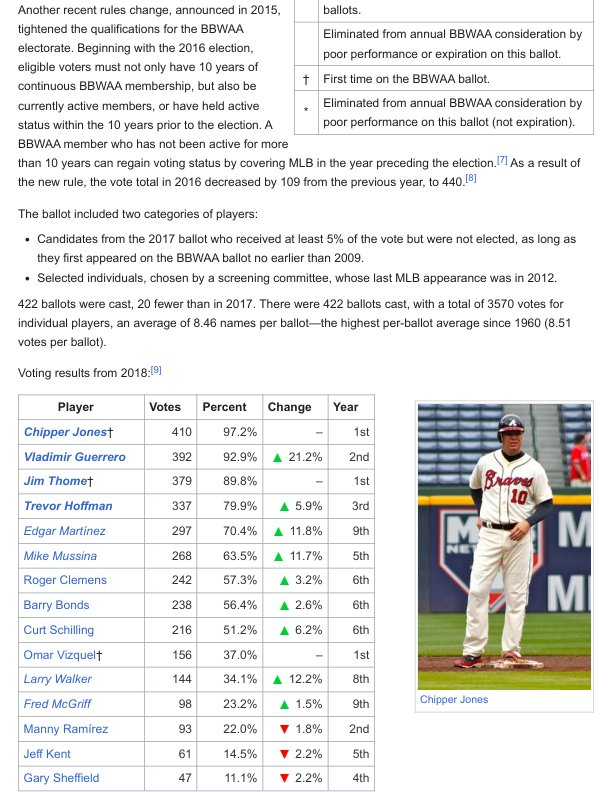

Image {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=612x792 at 0x7AE3051E3A50>}


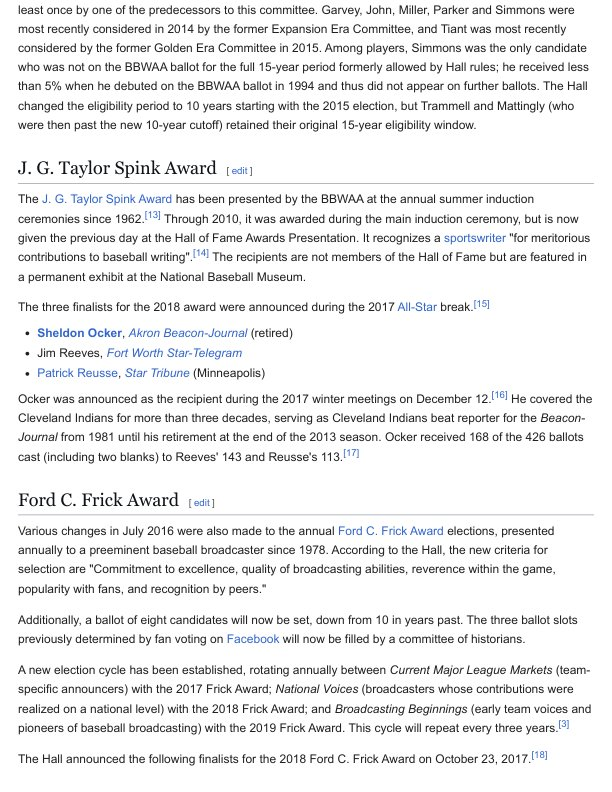

Image {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=612x792 at 0x7AE3051E39D0>}


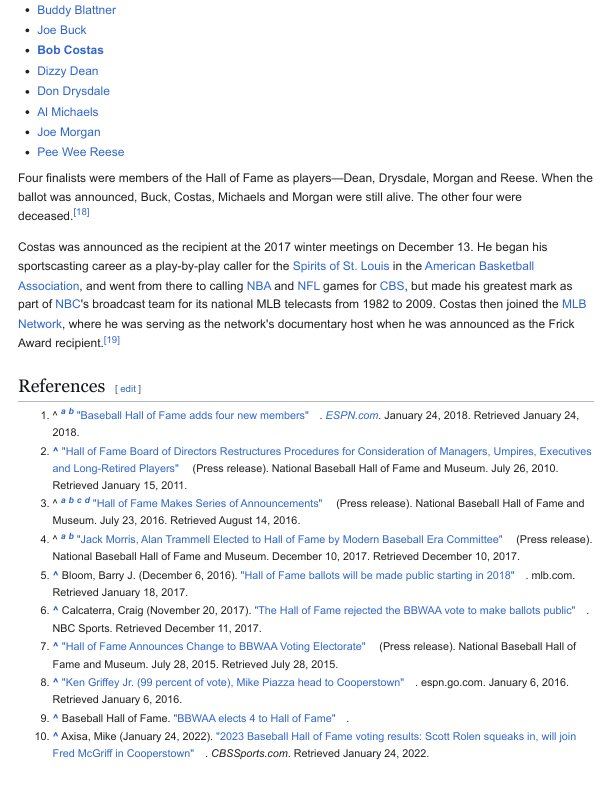

In [ ]:
results_ds = search_by_text_and_return_images("2023 ballot")

for row in results_ds:
    # display image
    print(f"Image {row}")
    display(row["image"])